# INTRODUCTION

Regression analysis is a statistical technique that is used to predict a continuous variable from one or more independent variables. The dependent variable is the variable that is being predicted, and the independent variables are the variables that are used to predict the dependent variable.

In this machine learning regression project, the goal is to develop a model that can accurately predict the value of the dependent variable based on the values of the independent variables. The model is developed by training the algorithm on a dataset of historical data. The algorithm learns from the data and identifies patterns that can be used to predict the value of the dependent variable.

Once the model is trained, it can be used to predict the value of the dependent variable for new data points. This can be used to make decisions about future outcomes, such as predicting sales, forecasting demand, or assessing risk.

# BUSINESS UNDERSTANDING

This is a time series forecasting problem. In this project, we'll predict store sales on data from **Corporation Favorita**, a large Ecuadorian-based grocery retailer.

Specifically, we are to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

# IMPORTATION

In [150]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

# DATA LOADING

Create a .env file in root of the folder of the project and all the sensitive information in the .env file

In [86]:
# Load environment variables from a .env file
env_variables = dotenv_values('../.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

Create a .gitignore file and type '/.env/' file we just created. This will prevent git from tracking the file.

Create a connection by accessing your connection string with your defined environment variables 

In [87]:
# Setup connection string to connect to the remote server
connection_string = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

Setup the links and queries to read the data from the various sources

In [88]:
# Query statement to fetch oil, holidays_events and stores data from the remote server
oil_query = 'SELECT * FROM dbo.oil'
holidays_query = 'SELECT * FROM dbo.holidays_events'
stores_query = 'SELECT * FROM dbo.stores'

In [89]:
# Read all data from different sources
oil = pd.read_sql_query(oil_query, connection_string, parse_dates=['date'])
holidays_events = pd.read_sql_query(holidays_query, connection_string, parse_dates=['date'])
stores = pd.read_sql_query(stores_query, connection_string)
transactions = pd.read_csv('./data/transactions.csv', parse_dates=['date'])
train = pd.read_csv('./data/train.csv', parse_dates=['date'])
test = pd.read_csv('./data/test.csv', parse_dates=['date'])

# DATA UNDERSTANDING

# EXPLORATORY DATA ANALYSIS (EDA)

Use various pandas methods to get preliminary information about the various datasets

In [90]:
# View the first 5 rows of the oil dataset
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [91]:
# View the last 5 rows of the oil dataset
oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999
1217,2017-08-31,47.259998


In [92]:
# View the first 5 rows of the holidays_events dataset
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [93]:
# View the last 5 rows of the holidays_events dataset
holidays_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [94]:
# View the first 5 rows of the stores dataset
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [95]:
# View the last 5 rows of the stores dataset
stores.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [96]:
# View the first 5 rows of the transactions dataset
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [97]:
# View the last 5 rows of the transactions dataset
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [98]:
# View the first 5 rows of the train dataset
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [99]:
# View the first 5 rows of the test dataset
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [100]:
# View the last 5 rows of the test dataset
test.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


In [101]:
# Get more information about each dataset

def get_info_df(df: pd.DataFrame):
    print('============ Shape ============')
    print(df.shape)
    print('============ Data Types ============')
    print(df.info())
    print('============ Missing Values ============')
    print(df.isnull().sum())
    print('============ Duplicated Values ============')
    print(df.duplicated().sum())
    

In [102]:
# Get more info on the oil dataset
get_info_df(oil)

============ Shape ============
(1218, 2)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None
============ Missing Values ============
date           0
dcoilwtico    43
dtype: int64
============ Duplicated Values ============
0


In [103]:
# Get more info on the holidays_events dataset
get_info_df(holidays_events)

============ Shape ============
(350, 6)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None
============ Missing Values ============
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
============ Duplicated Values ============
0


In [104]:
# Get more info on the stores dataset
get_info_df(stores)

============ Shape ============
(54, 5)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
============ Missing Values ============
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
============ Duplicated Values ============
0


In [105]:
# Get more info on the transactions dataset
get_info_df(transactions)

============ Shape ============
(83488, 3)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
None
============ Missing Values ============
date            0
store_nbr       0
transactions    0
dtype: int64
============ Duplicated Values ============
0


In [106]:
# Get more info on the train dataset
get_info_df(train)

============ Shape ============
(3000888, 6)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
============ Missing Values ============
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
============ Duplicated Values ============


0


In [107]:
# Get more info on the test dataset
get_info_df(test)

============ Shape ============
(28512, 5)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None
============ Missing Values ============
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
============ Duplicated Values ============
0


In [108]:
# Define a function to check for the number of unique values in categorical columns
def check_unique_values(df: pd.DataFrame):
    """
    Check the number of unique values in the categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print("Checking unique values in categorical columns:")

    # Iterate through each column
    for col in df.columns:
        # Check if the column is categorical (object type) and not the 'customerID' column
        if ((df[col].dtype == 'object') or (df[col].dtype == 'bool')) and (col != 'id'):
            # Print the column name and its unique values
            print(col, '---->', df[col].unique())

In [109]:
# Call the function to check unique values for the stores dataset
check_unique_values(stores)

Checking unique values in categorical columns:
city ----> ['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state ----> ['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type ----> ['D' 'B' 'C' 'E' 'A']


In [110]:
# Call the function to check unique values for the holidays_events dataset
check_unique_values(holidays_events)

Checking unique values in categorical columns:
type ----> ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
locale ----> ['Local' 'Regional' 'National']
locale_name ----> ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
description ----> ['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fundacion de Ambato' 'Fundacion de Ibarra' 'Cantonizacion de Quevedo'
 '

In [111]:
# Call the function to check unique values for the train dataset
check_unique_values(train)

Checking unique values in categorical columns:
family ----> ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


## DATA ASSESSMENT

Following data gathering from various sources, a comprehensive assessment was conducted to evaluate quality issues both visually and programmatically.

### DATA QUALITY ISSUES


During the preliminary dataset exploration, several data quality issues were identified, and they are summarized below:

   
1. Completeness:
   - Missing data points in the dcoilwtico column of the oil dataset.


# HYPOTHESIS

# ANALYTICAL QUESTIONS

# DATA CLEANING

In [112]:
# Rename the "dcoilwtico" column to "price"
oil.rename(columns={'dcoilwtico': 'price'}, inplace=True)


In [113]:
# Confirm changes
oil.head()

,date,price
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


# DATA MERGING

In [114]:
# Define a function that check the matching columns across all the dataset 

# Define a Class that assigns the name to the Dataset
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name

# Define a function that output the matching pairs
def find_matching_columns_in_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]

                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [115]:
# Define the dataset names
datasets = [
    (oil, 'Oil'),
    (holidays_events, 'Holidays Events'),
    (stores, 'Stores'),
    (transactions, 'Transactions'),
    (train, 'Train'),
    (test, 'Test'),
]

# Apply the function to check the pairs
find_matching_columns_in_pairs(datasets)

Matching columns between Oil and Holidays Events: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays Events and Stores: ['type']
Matching columns between Holidays Events and Transactions: ['date']
Matching columns between Holidays Events and Train: ['date']
Matching columns between Holidays Events and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'family', 'onpromotion']


In [142]:
# Define a function that compares the two dates and also check the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [143]:
# Apply the function to compare for Transaction and Train
compare_result_train= date_comparison(transactions['date'], train['date'])

# print
pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [144]:
# Apply the function to compare for Transaction and Test
compare_result_test= date_comparison(transactions['date'], test['date'])

# print
pd.DataFrame(compare_result_test)

,Common,Uncommon,Date Range 1,Date Range 2
0,0,1698,2013-01-01,2017-08-16
1,0,1698,2017-08-15,2017-08-31


In [145]:
# Merge the Oil data to the Train and Test
train = train.merge(oil, on=['date'])
test = test.merge(oil, on=['date'])

In [146]:
# Merge holidays events, stores and transactions to the Train
train = train.merge(stores, on=['store_nbr'])
train = train.merge(holidays_events, on=['date'])
train = train.merge(transactions, on=['date', 'store_nbr'])

In [148]:
# Confirm the merged columns to the train
train

,id,date,store_nbr,family,sales,onpromotion,price,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.000,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.000,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.000,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.000,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
322043,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
322044,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
322045,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155


In [152]:
# Rename the type_x and type_y
train.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [153]:
# Check for missing values
train.isnull().sum()


id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
price           22044
city                0
state               0
holiday_type        0
cluster             0
store_type          0
locale              0
locale_name         0
description         0
transferred         0
transactions        0
dtype: int64

<Axes: >

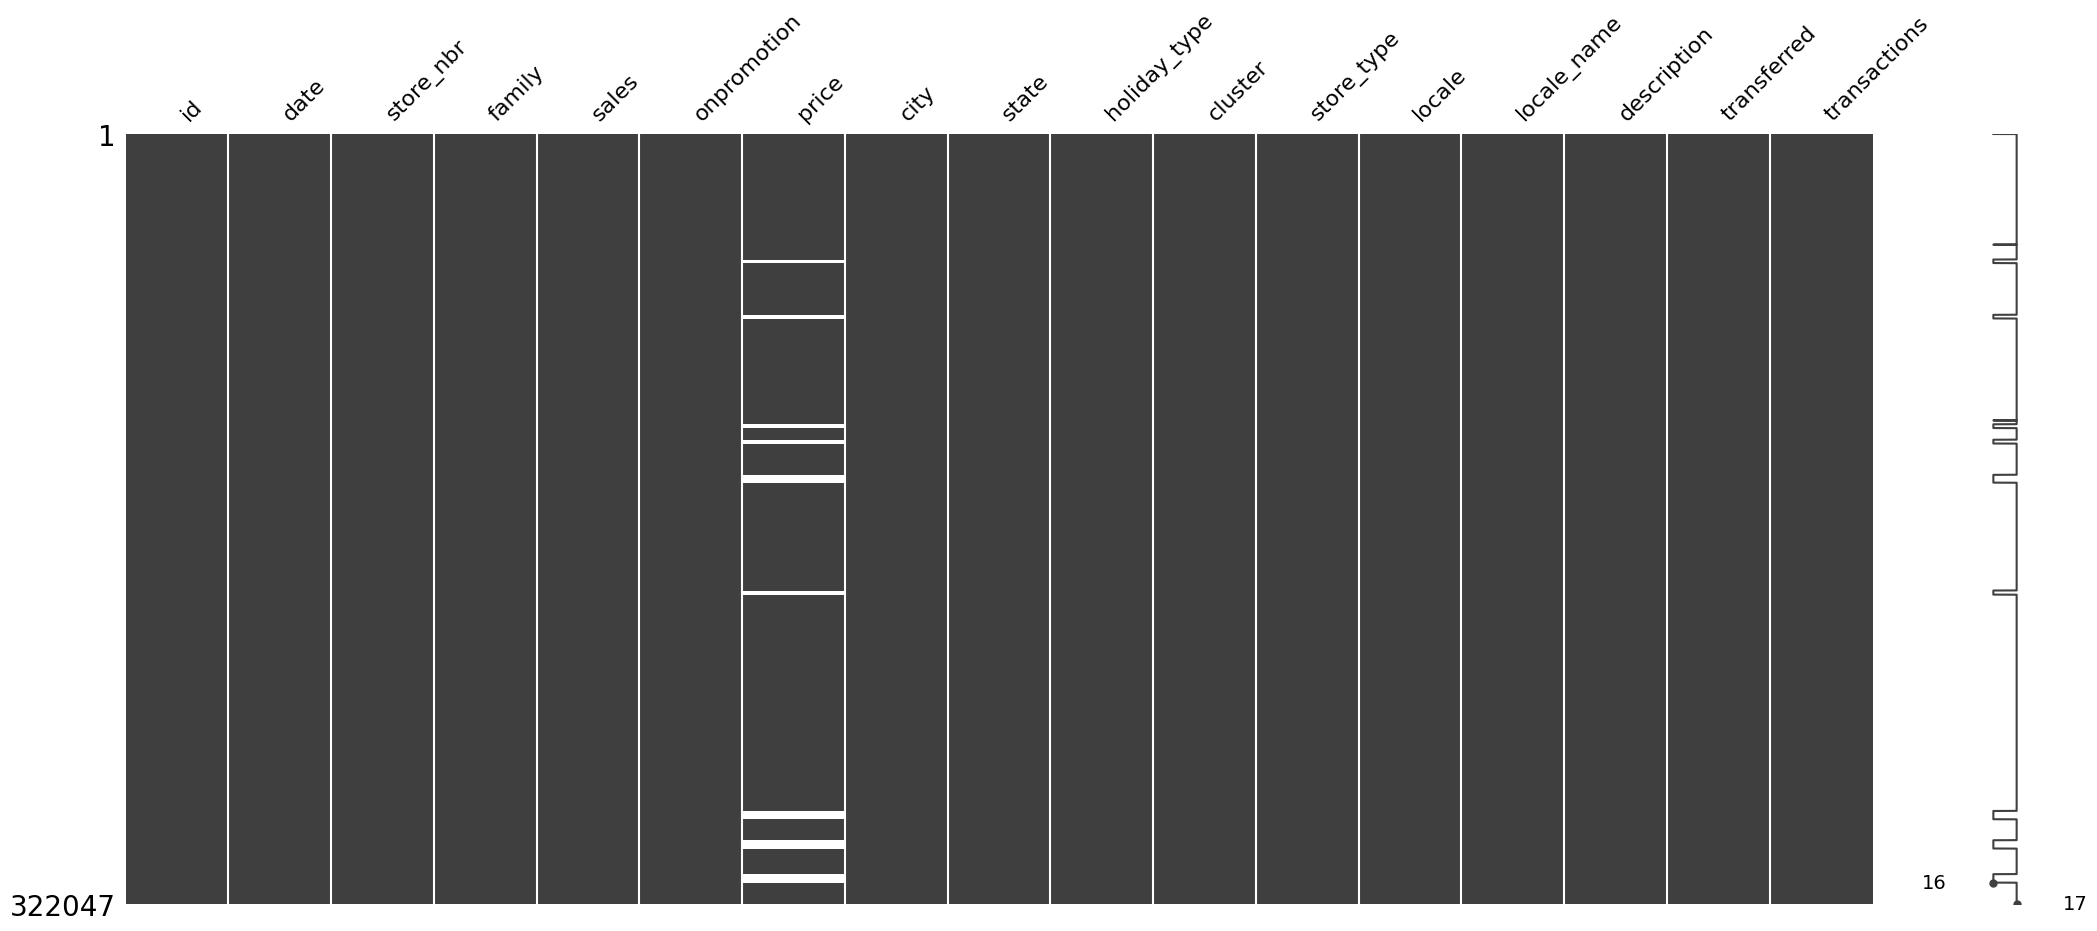

In [154]:
# Visualize the missing values
msno.matrix(train)

After merging the train datasets contains 322,047 rows and 17 columns and includes information about sales, promotions, prices, store locations, holidays, and more. Notably, the "price" column has 22,044 missing values, which will be handled properly during the data preprocessing stage.

In [ ]:
# Define custom color palette
custom_color_palette = ["#835AF1","#37AA9C", "#B8F7D4", "#94F3E4"]

# Set the custom color palette for Plotly Express
px.defaults.color_discrete_sequence = custom_color_palette